In [17]:
#Basic libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import ast
import datetime
from PIL import Image
from io import BytesIO
from datetime import datetime as dt

#Drop future warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

#Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
from imblearn.pipeline import Pipeline as smpipe
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [18]:
recession_vs_yield = pd.read_csv('data/preprocessed_2.csv', index_col = 'Date')
recession_vs_yield = recession_vs_yield.set_index(pd.DatetimeIndex(recession_vs_yield.index))
recession_vs_yield = recession_vs_yield.rename(columns= {'Value': 'Unemployment', 'spread': 'Yield spread'})

#Generate the different features
data_mean = recession_vs_yield.resample('Q-JAN', convention='end').agg('mean')
data_mean['USREC'] = data_mean['USREC'].apply(lambda x: 1 if x > 0 else 0)
data_std = recession_vs_yield.resample('Q-JAN', convention='end').agg('std').drop(columns = ['USREC'])
data_split = recession_vs_yield.resample('Q-JAN', convention='end').agg('max') - recession_vs_yield.resample('Q-JAN', convention='end').agg('min')
data_split = data_split.drop(columns = ['USREC']).add_suffix('_split')

#Merge them features
data = pd.merge_asof(data_mean,data_std, left_index = True, right_index = True, suffixes = ('_mean','_std'))
data = pd.merge_asof(data,data_split, left_index = True, right_index = True)
data = data.iloc[1:-1 , :]
data['USREC'] = data['USREC'].shift(periods = -1)
data = data.iloc[:-1,:]

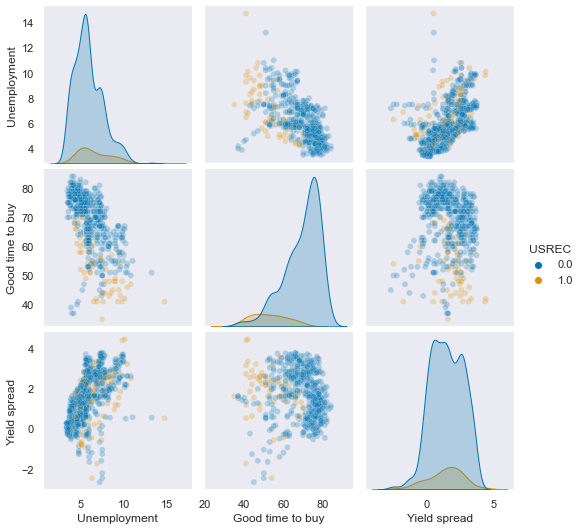

In [19]:
#sns.set(rc={'axes.facecolor':'#a8aaad', 'figure.facecolor':'#a8aaad'})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette("colorblind")
with sns.axes_style("dark"):

    sns.pairplot(recession_vs_yield.drop(columns = ['Value_10yr','Value_3mon', 'Uncertain - depends', 'housing market','Bad time to buy', 'Relative']), hue = 'USREC', plot_kws={'alpha': 0.25})
plt.savefig('figures/pairplots.png', transparent=True, dpi = 400, bbox_inches='tight');

In [4]:
#Set the global X and y variables
X = data.drop(columns = ['USREC'])
y = data['USREC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)


In [5]:
#Logistic regression model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()),('scaler', StandardScaler()), ('rgsr', LogisticRegression(max_iter=9000))]
lr_pipe = smpipe(steps = steps)
lr_grid = [{'rgsr__C': [1e4,1e6], 'rgsr__solver': ['newton-cg', "lbfgs", 'liblinear', 'sag', 'saga']}]
lr_grid_search = GridSearchCV(estimator = lr_pipe, param_grid = lr_grid,cv = 5, scoring = 'recall')

#Random forest classifier model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()), ('scaler', StandardScaler()), ('rgsr', RandomForestClassifier())]
rf_pipe = smpipe(steps = steps)
rf_grid = [{'rgsr__n_estimators': range(50,1000,50), 'rgsr__max_depth': [2,3,4], 'rgsr__min_samples_leaf': [4]}]
rf_grid_search = GridSearchCV(estimator = rf_pipe, param_grid = rf_grid, cv = 5, scoring = 'recall')

#XGBoost classifier model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()),('scaler', StandardScaler()), ('rgsr', GradientBoostingClassifier())]
xg_pipe = smpipe(steps = steps)
xg_grid = [{'rgsr__n_estimators': range(50,1000,50)}]
xg_grid_search = GridSearchCV(estimator = xg_pipe, param_grid = xg_grid, cv = 5, scoring = 'f1')

#Fit the models
lr_grid_search.fit(X_train,y_train)
rf_grid_search.fit(X_train,y_train)
xg_grid_search.fit(X_train,y_train)

#Report accuracy
print('Logistic regression recall: ', recall_score(y_test,lr_grid_search.predict(X_test)))
print('Random forest regression recall: ', recall_score(y_test,rf_grid_search.predict(X_test)))
print('XGBoost regression recall: ', recall_score(y_test,xg_grid_search.predict(X_test)))

Logistic regression recall:  0.9
Random forest regression recall:  0.8
XGBoost regression recall:  0.8


In [217]:
rf_grid_search.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('smote', SMOTE()), ('scaler', StandardScaler()),
                ('rgsr',
                 RandomForestClassifier(max_depth=2, min_samples_leaf=4,
                                        n_estimators=80))])

Area under the curve logistic regression:  0.8887
Area under the curve random forest:  0.9274
Area under the curve XGBoost:  0.9435


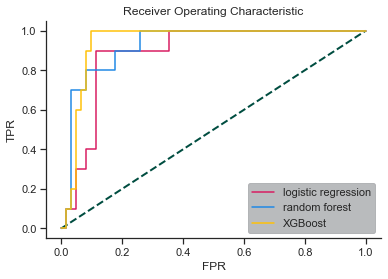

In [10]:
#For the logistic regression ROC
fpr, tpr, thresholds = roc_curve(y_test, lr_grid_search.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot(fpr,tpr, label = 'logistic regression', c = '#D81B60')
plt.plot([0, 1], [0, 1], color="#004D40", lw=2, linestyle="--")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characteristic')
aucscore = auc(fpr,tpr)
print('Area under the curve logistic regression: ',round(aucscore,4))

#For the random forest ROC
fpr, tpr, thresholds = roc_curve(y_test, rf_grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr, label = 'random forest', c = '#1E88E5')
aucscore = auc(fpr,tpr)
print('Area under the curve random forest: ',round(aucscore,4))

#For the random forest ROC
fpr, tpr, thresholds = roc_curve(y_test, xg_grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr, label = 'XGBoost', c = '#FFC107')
aucscore = auc(fpr,tpr)
print('Area under the curve XGBoost: ',round(aucscore,4))


legend = plt.legend(loc = 'best')
frame = legend.get_frame()
frame.set_color('#a8aaad')
plt.savefig('figures/ROC.png', transparent=True, dpi = 800, bbox_inches='tight');

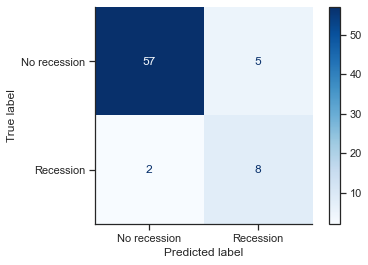

In [26]:
threshold = .5
y_probas = rf_grid_search.predict_proba(X_test)[:,1]
custom_thresh_y_pred_test = [1 if y > threshold else 0 for y in y_probas]
conf = confusion_matrix(y_test,np.array(custom_thresh_y_pred_test))
#disp = ConfusionMatrixDisplay()
disp = ConfusionMatrixDisplay.from_estimator(rf_grid_search,X_test,y_test,display_labels=('No recession','Recession'), cmap = plt.cm.Blues)
#disp.plot()
plt.savefig('figures/confMat.png', transparent=True, dpi = 800, bbox_inches='tight');

In [338]:
from sklearn.metrics import classification_report
report = classification_report(y_test,custom_thresh_y_pred_test, output_dict = True)
report;

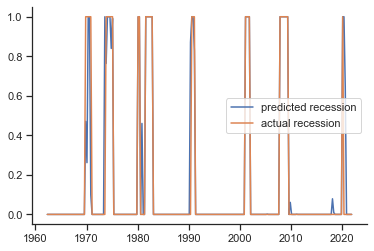

In [339]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(xg_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')

#plt.axis([dt.fromisoformat('1979-07-01'), dt.fromisoformat('1980-07-01'), 0, 1]);

''

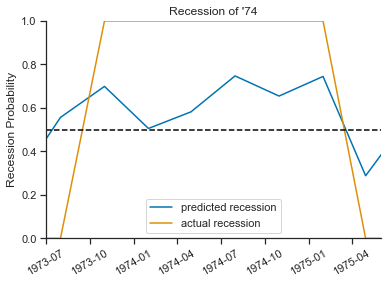

In [20]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of \'74')
plt.axis([dt.fromisoformat('1973-07-01'), dt.fromisoformat('1975-06-01'), 0, 1])
plt.savefig('figures/recession_of_74.png', transparent=True, dpi = 800, bbox_inches='tight')
;

''

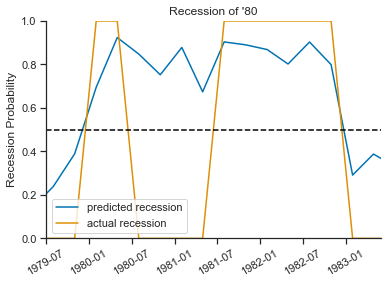

In [21]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of \'80')
plt.axis([dt.fromisoformat('1979-07-01'), dt.fromisoformat('1983-06-01'), 0, 1])
plt.savefig('figures/recession_of_80.png', transparent=True, dpi = 800, bbox_inches='tight')
;

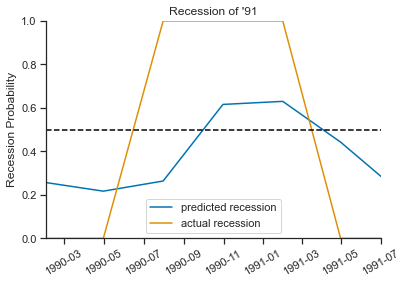

In [22]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of \'91')
plt.axis([dt.fromisoformat('1990-02-01'), dt.fromisoformat('1991-07-01'), 0, 1])
plt.savefig('figures/recession_of_91.png', transparent=True, dpi = 800, bbox_inches='tight');

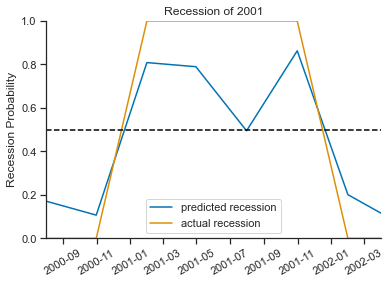

In [23]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of 2001')
plt.axis([dt.fromisoformat('2000-08-01'), dt.fromisoformat('2002-04-01'), 0, 1])
plt.savefig('figures/recession_of_2001.png', transparent=True, dpi = 800, bbox_inches='tight');

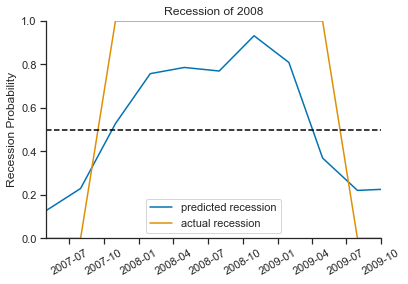

In [24]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of 2008')
plt.axis([dt.fromisoformat('2007-05-01'), dt.fromisoformat('2009-10-01'), 0, 1])
plt.savefig('figures/recession_of_2008.png', transparent=True, dpi = 800, bbox_inches='tight');

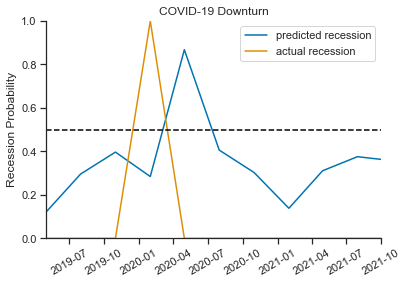

In [27]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('COVID-19 Downturn')
plt.axis([dt.fromisoformat('2019-05-01'), dt.fromisoformat('2021-10-01'), 0, 1])
plt.savefig('figures/COVID.png', transparent=True, dpi = 800, bbox_inches='tight');